In [12]:
import numpy as np
import random
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef,
    roc_auc_score, roc_curve, auc
)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)

TF version: 2.20.0


In [13]:
def infer_label(header: str):
    """Infer species from VISTA-like headers."""
    h = header.lower()
    if h.startswith("human"):
        return "human"
    if h.startswith("mouse"):
        return "mouse"
    if "homo" in h or "hs" in h:
        return "human"
    if "mus" in h or "mm" in h:
        return "mouse"
    # last fallback (still safe for your file)
    if "human" in h:
        return "human"
    if "mouse" in h:
        return "mouse"
    raise ValueError("Cannot infer label from header: " + header)


def load_fasta(path):
    sequences = []
    labels = []
    buf = []
    current_label = None

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if buf and current_label is not None:
                    sequences.append("".join(buf).upper())
                    labels.append(current_label)
                header = line[1:].strip()
                current_label = infer_label(header)
                buf = []
            else:
                buf.append(line.replace(" ", "").replace("\t", ""))
        # last one
        if buf and current_label is not None:
            sequences.append("".join(buf).upper())
            labels.append(current_label)

    return sequences, labels

sequences_raw, labels = load_fasta("Vista_Dataset/vista_sequences.fasta")
print("Loaded:", len(sequences_raw), "sequences")
print("Unique labels:", set(labels))

Loaded: 3408 sequences
Unique labels: {'mouse', 'human'}


In [14]:

MAXLEN = 3000

def trim_center(seq, maxlen=MAXLEN):
    if len(seq) <= maxlen:
        return seq
    mid = len(seq) // 2
    start = mid - maxlen // 2
    return seq[start:start+maxlen]

sequences = [trim_center(s) for s in sequences_raw]
print("Max length after trimming:", max(len(s) for s in sequences))
print("Min length after trimming:", min(len(s) for s in sequences))


Max length after trimming: 3000
Min length after trimming: 188


In [15]:
INTEGER = {"A":1.0, "C":3.0, "G":2.0, "T":4.0}
ATOMIC  = {"A":70.0, "C":58.0, "G":78.0, "T":66.0}
EIIP    = {"A":0.1260, "C":0.1340, "G":0.0806, "T":0.1335}

def encode_map(seq, mapping):
    return [mapping.get(nt, 0.0) for nt in seq]

def encode_bfdna(seq):
    c = Counter(seq)
    total = len(seq)
    freqs = {b: c.get(b, 0) / total for b in "ACGT"}
    return [freqs.get(nt, 0.0) for nt in seq]

def encode_sequences(seqs, scheme):
    if scheme == "integer":
        mapping = INTEGER
    elif scheme == "atomic":
        mapping = ATOMIC
    elif scheme == "eiip":
        mapping = EIIP
    elif scheme == "bfdna":
        mapping = None
    else:
        raise ValueError("Unknown scheme: " + scheme)

    X = np.zeros((len(seqs), MAXLEN), dtype=np.float32)

    for i, s in enumerate(seqs):
        if scheme == "bfdna":
            enc = encode_bfdna(s)
        else:
            enc = encode_map(s, mapping)
        L = min(len(enc), MAXLEN)
        X[i, :L] = enc[:L]

    # normalize ignoring zeros
    mask = X != 0
    if np.any(mask):
        vmin, vmax = X[mask].min(), X[mask].max()
        if vmax > vmin:
            X[mask] = (X[mask] - vmin) / (vmax - vmin)

    return X[..., np.newaxis]   # shape: (N, MAXLEN, 1)

In [16]:
NUCS = ["A", "C", "G", "T"]
K = 3
KMER_LIST = ["".join(p) for p in itertools.product(NUCS, repeat=K)]
KMER_INDEX = {kmer:i for i,kmer in enumerate(KMER_LIST)}

def kmer_vector(seq, k=K):
    vec = np.zeros(len(KMER_LIST), dtype=np.float32)
    if len(seq) < k:
        return vec
    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]
        if any(ch not in "ACGT" for ch in kmer):
            continue
        idx = KMER_INDEX[kmer]
        vec[idx] += 1
    # normalize to frequencies
    total = vec.sum()
    if total > 0:
        vec /= total
    return vec

def basic_composition_features(seq):
    seq = "".join(ch for ch in seq if ch in "ACGT")
    L = len(seq)
    if L == 0:
        return np.zeros(4, dtype=np.float32)
    counts = Counter(seq)
    gc = (counts.get("G",0) + counts.get("C",0)) / L
    at = (counts.get("A",0) + counts.get("T",0)) / L
    # CpG count normalized
    cpg = seq.count("CG") / L
    length_norm = L / MAXLEN
    return np.array([gc, at, cpg, length_norm], dtype=np.float32)

def extract_features(seqs):
    feats = []
    for s in seqs:
        kv = kmer_vector(s)
        comp = basic_composition_features(s)
        feats.append(np.concatenate([kv, comp]))
    feats = np.stack(feats, axis=0)
    return feats  # shape (N, 64+4)

X_feats_raw = extract_features(sequences)
print("Feature shape:", X_feats_raw.shape)


Feature shape: (3408, 68)


In [17]:
label_enc = LabelEncoder()
y = label_enc.fit_transform(labels)  # 0/1 for human/mouse

idx = np.arange(len(y))

train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=SEED, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.2/0.8, random_state=SEED, stratify=y[train_idx]
)

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))

# scale handcrafted features using training set only
scaler = StandardScaler()
X_feats_train = scaler.fit_transform(X_feats_raw[train_idx])
X_feats_val   = scaler.transform(X_feats_raw[val_idx])
X_feats_test  = scaler.transform(X_feats_raw[test_idx])

feat_dim = X_feats_train.shape[1]
print("Feature dim:", feat_dim)

Train: 2044 Val: 682 Test: 682
Feature dim: 68


In [18]:
def build_hybrid_model(input_seq_shape, feature_dim):
    """
    input_seq_shape: (MAXLEN, 1)
    feature_dim: dimension of handcrafted feature vector
    """

    # Sequence branch
    seq_input = layers.Input(shape=input_seq_shape, name="seq_input")

    x = layers.Conv1D(64, 7, padding="same", activation="selu")(seq_input)
    x = layers.MaxPooling1D(4)(x)            # 1000 -> 250

    x = layers.Conv1D(128, 5, padding="same", activation="selu")(x)
    x = layers.MaxPooling1D(4)(x)            # 250 -> ~62

    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=True)
    )(x)
    x = layers.Bidirectional(
        layers.GRU(32, return_sequences=True)
    )(x)

    # Multi-head self-attention
    attn_out = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_out])  # residual connection
    x = layers.LayerNormalization()(x)

    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)
    seq_emb = layers.Dense(128, activation="selu")(x)

    # Handcrafted feature branch
    feat_input = layers.Input(shape=(feature_dim,), name="feat_input")
    f = layers.Dense(64, activation="selu")(feat_input)

    # Fusion
    h = layers.Concatenate()([seq_emb, f])
    h = layers.Dense(128, activation="selu")(h)
    h = layers.Dropout(0.3)(h)
    h = layers.Dense(64, activation="selu")(h)

    out = layers.Dense(1, activation="sigmoid")(h)

    model = models.Model(inputs=[seq_input, feat_input], outputs=out)
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

In [19]:
import os
def compute_metrics_binary(y_true, y_prob, thresh=0.5):
    y_pred = (y_prob >= thresh).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sp = tn / (tn + fp) if (tn + fp) > 0 else 0
    rc = tp / (tp + fn) if (tp + fn) > 0 else 0

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    csi  = prec + rc - 1
    gmean = np.sqrt(sp * rc) if sp * rc > 0 else 0
    mcc  = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rc,
        "f1": f1,
        "CSI": csi,
        "G-mean": gmean,
        "MCC": mcc,
        "Kappa": kappa,
        "AUC": auc_score,
        "CM": cm
    }

def plot_cm(cm, title, save_path=None):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=label_enc.classes_,
                yticklabels=label_enc.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Confusion Matrix saved to {save_path}")
    plt.show()

def plot_roc(y_true, y_prob, title, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if save_path:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"ROC Curve saved to {save_path}")
        
    plt.show()



Encoding: integer


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 3000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 750, 64)   │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 750, 128)  │     41,088 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 187, 128)  │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 187, 128)  │     74,496 │ max_pooling1d_9[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 187, 64)   │     31,104 │ bidirectional_8[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 64)   │     33,216 │ bidirectional_9[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 187, 64)   │          0 │ bidirectional_9[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 192)       │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │     24,704 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │         65 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 226,305 (884.00 KB)

 Trainable params: 226,305 (884.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.7324 - auc: 0.8004 - loss: 0.5644 - val_accuracy: 0.8050 - val_auc: 0.8817 - val_loss: 0.4369
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.7940 - auc: 0.8749 - loss: 0.4440 - val_accuracy: 0.8299 - val_auc: 0.8968 - val_loss: 0.4047
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.8219 - auc: 0.8981 - loss: 0.4006 - val_accuracy: 0.8270 - val_auc: 0.8991 - val_loss: 0.3948
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.8351 - auc: 0.9080 - loss: 0.3798 - val_accuracy: 0.8138 - val_auc: 0.8993 - val_loss: 0.3968
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.8327 - auc: 0.9094 - loss: 0.3768 - val_accuracy: 0.8284 - val_auc: 0.9054 - val_loss: 0.3985
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.8430 - auc: 0.9193 - loss: 0.3550 - val_accuracy: 0.8167 - val_auc: 0.9029 - val_loss: 0.4013
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━

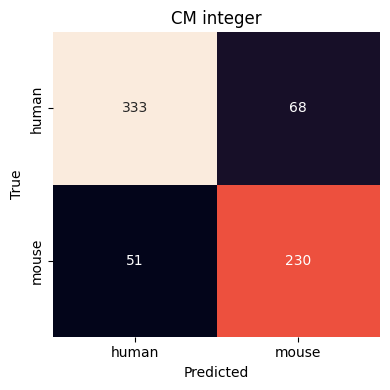

ROC Curve saved to results/integer_roc.png


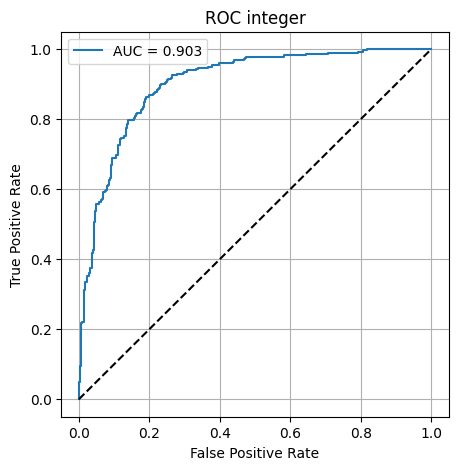



Encoding: atomic


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 3000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 750, 64)   │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 750, 128)  │     41,088 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 187, 128)  │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 187, 128)  │     74,496 │ max_pooling1d_11… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 187, 64)   │     31,104 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 64)   │     33,216 │ bidirectional_11… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 187, 64)   │          0 │ bidirectional_11… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 192)       │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │     24,704 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         65 │ dense_28[0][0]  

 Total params: 226,305 (884.00 KB)

 Trainable params: 226,305 (884.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.7192 - auc: 0.7865 - loss: 0.5960 - val_accuracy: 0.8094 - val_auc: 0.8839 - val_loss: 0.4344
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.8058 - auc: 0.8811 - loss: 0.4326 - val_accuracy: 0.8255 - val_auc: 0.8969 - val_loss: 0.4002
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.8141 - auc: 0.8973 - loss: 0.3998 - val_accuracy: 0.8270 - val_auc: 0.9035 - val_loss: 0.3886
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.8239 - auc: 0.9036 - loss: 0.3869 - val_accuracy: 0.8387 - val_auc: 0.9036 - val_loss: 0.3936
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.8366 - auc: 0.9151 - loss: 0.3635 - val_accuracy: 0.8196 - val_auc: 0.9043 - val_loss: 0.3865
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.8459 - auc: 0.9175 - loss: 0.3580 - val_accuracy: 0.8299 - val_auc: 0.9022 - val_loss: 0.3988
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━

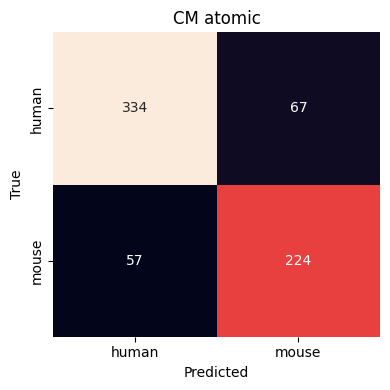

ROC Curve saved to results/atomic_roc.png


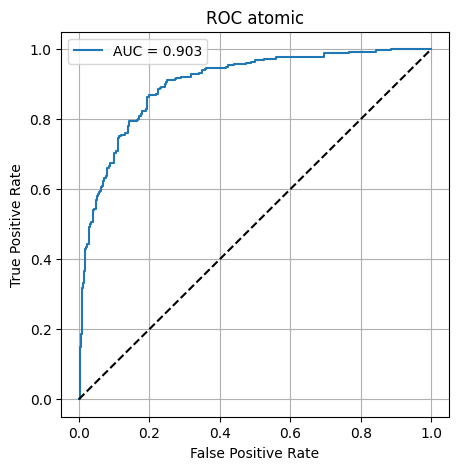



Encoding: eiip


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 3000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 750, 64)   │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 750, 128)  │     41,088 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 187, 128)  │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 187, 128)  │     74,496 │ max_pooling1d_13… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 187, 64)   │     31,104 │ bidirectional_12… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 64)   │     33,216 │ bidirectional_13… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 187, 64)   │          0 │ bidirectional_13… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 64)   │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 192)       │          0 │ dense_30[0][0],   │
│ (Concatenate)       │                   │            │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     24,704 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1)         │         65 │ dense_33[0][0]  

 Total params: 226,305 (884.00 KB)

 Trainable params: 226,305 (884.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.7490 - auc: 0.8083 - loss: 0.5504 - val_accuracy: 0.8094 - val_auc: 0.8855 - val_loss: 0.4193
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.8019 - auc: 0.8865 - loss: 0.4184 - val_accuracy: 0.8138 - val_auc: 0.8953 - val_loss: 0.4032
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.8141 - auc: 0.8971 - loss: 0.3991 - val_accuracy: 0.8196 - val_auc: 0.8939 - val_loss: 0.4050
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.8293 - auc: 0.9013 - loss: 0.3928 - val_accuracy: 0.8240 - val_auc: 0.9043 - val_loss: 0.3861
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.8346 - auc: 0.9103 - loss: 0.3738 - val_accuracy: 0.8328 - val_auc: 0.9036 - val_loss: 0.3916
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.8332 - auc: 0.9146 - loss: 0.3632 - val_accuracy: 0.8284 - val_auc: 0.9064 - val_loss: 0.3868
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━

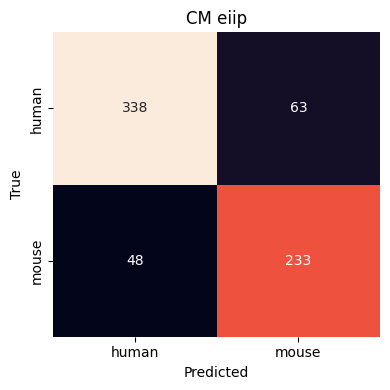

ROC Curve saved to results/eiip_roc.png


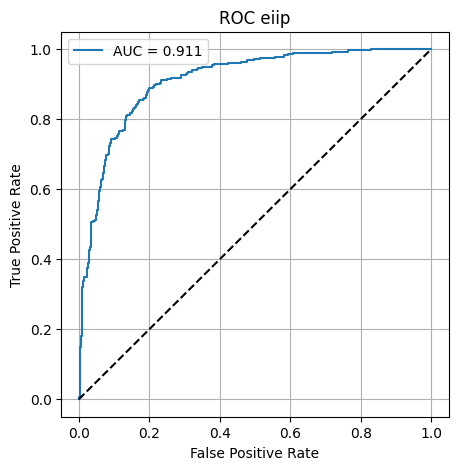



Encoding: bfdna


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 3000, 64)  │        512 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 750, 64)   │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 750, 128)  │     41,088 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 187, 128)  │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 187, 128)  │     74,496 │ max_pooling1d_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 187, 64)   │     31,104 │ bidirectional_14… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 64)   │     33,216 │ bidirectional_15… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 187, 64)   │          0 │ bidirectional_15… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 64)   │        128 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_input          │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 64)        │      4,416 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 192)       │          0 │ dense_35[0][0],   │
│ (Concatenate)       │                   │            │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 128)       │     24,704 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │      8,256 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1)         │         65 │ dense_38[0][0]  

 Total params: 226,305 (884.00 KB)

 Trainable params: 226,305 (884.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.7299 - auc: 0.7899 - loss: 0.6007 - val_accuracy: 0.7947 - val_auc: 0.8762 - val_loss: 0.4470
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.7989 - auc: 0.8788 - loss: 0.4335 - val_accuracy: 0.8255 - val_auc: 0.8928 - val_loss: 0.4068
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.8146 - auc: 0.8946 - loss: 0.4039 - val_accuracy: 0.8270 - val_auc: 0.8981 - val_loss: 0.3986
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.8351 - auc: 0.9085 - loss: 0.3769 - val_accuracy: 0.8196 - val_auc: 0.9000 - val_loss: 0.3963
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.8361 - auc: 0.9146 - loss: 0.3638 - val_accuracy: 0.8138 - val_auc: 0.9003 - val_loss: 0.4017
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.8410 - auc: 0.9171 - loss: 0.3580 - val_accuracy: 0.8138 - val_auc: 0.9043 - val_loss: 0.3886
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━

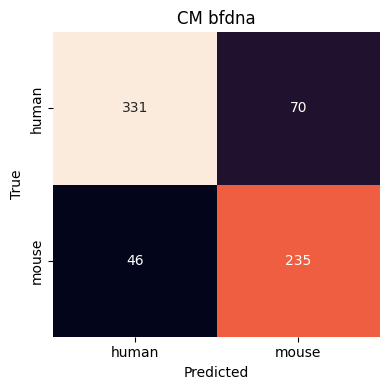

ROC Curve saved to results/bfdna_roc.png


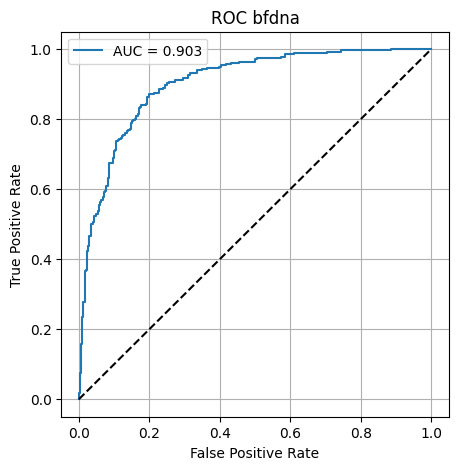

In [20]:
encodings = ["integer", "atomic", "eiip", "bfdna"]
all_results = {}

for scheme in encodings:
    print("\n\n==============================")
    print("Encoding:", scheme)
    print("==============================")

    # sequence encoding for this scheme
    X_seq = encode_sequences(sequences, scheme)
    input_seq_shape = X_seq.shape[1:]

    # split according to precalculated indices
    X_seq_train = X_seq[train_idx]
    X_seq_val   = X_seq[val_idx]
    X_seq_test  = X_seq[test_idx]

    y_train_split = y[train_idx]
    y_val_split   = y[val_idx]
    y_test_split  = y[test_idx]

    model = build_hybrid_model(input_seq_shape, feat_dim)
    model.summary()

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    if scheme == "bfdna":
        curr_epoch = 60
    else:
        curr_epoch = 20
    history = model.fit(
        [X_seq_train, X_feats_train], y_train_split,
        validation_data=([X_seq_val, X_feats_val], y_val_split),
        epochs=curr_epoch,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop]
    )

    # evaluation on test set
    y_prob_test = model.predict([X_seq_test, X_feats_test]).ravel()
    metrics = compute_metrics_binary(y_test_split, y_prob_test)
    all_results[scheme] = metrics

    print("\nTest metrics for", scheme)
    for k, v in metrics.items():
        if k == "CM":
            continue
        print(f"{k:>10}: {v:.4f}")

    # plots
    plot_cm(metrics["CM"], f"CM {scheme}", save_path=f"results/{scheme}_cm.png")
    plot_roc(y_test_split, y_prob_test, f"ROC {scheme}", save_path=f"results/{scheme}_roc.png")

In [10]:
rows = []
for scheme, m in all_results.items():
    rows.append({
        "Encoding": scheme,
        "Accuracy": m["accuracy"],
        "Precision": m["precision"],
        "Recall": m["recall"],
        "F1-score": m["f1"],
        "CSI": m["CSI"],
        "G-mean": m["G-mean"],
        "MCC": m["MCC"],
        "Kappa": m["Kappa"],
        "AUC": m["AUC"],
    })

df_results = pd.DataFrame(rows)
print("\nSummary (Scenario 1, GRU+Attn+Features):")
print(df_results.to_string(index=False, float_format=lambda x: f"{x*100:5.2f}%"))



Summary (Scenario 1, GRU+Attn+Features):
Encoding  Accuracy  Precision  Recall  F1-score    CSI  G-mean    MCC  Kappa    AUC
 integer    76.17%     67.32%  81.99%    73.93% 49.31%  76.88% 53.24% 52.38% 85.06%
  atomic    72.27%     62.55%  81.52%    70.78% 44.06%  73.23% 46.69% 45.25% 83.68%
    eiip    75.20%     65.91%  82.46%    73.26% 48.37%  76.03% 51.77% 50.66% 84.99%
   bfdna    75.98%     68.49%  77.25%    72.61% 45.74%  76.16% 51.65% 51.35% 85.11%
